In [1]:
import quandl
import pandas as pd
import numpy as np
import talib
import csv
import warnings
import seaborn as sns
from hmmlearn.hmm import GaussianHMM
from matplotlib import cm, pyplot as plt
from matplotlib.dates import YearLocator, MonthLocator

In [2]:
gold=quandl.get("PERTH/GOLD_USD_D", authtoken="B5RSB-jK5vYvZKyFBm4q")
silver=quandl.get("PERTH/SLVR_USD_D", authtoken="B5RSB-jK5vYvZKyFBm4q")
oil=quandl.get("FRED/DCOILWTICO", authtoken="B5RSB-jK5vYvZKyFBm4q")
ruthenium=quandl.get("JOHNMATT/RUTH", authtoken="B5RSB-jK5vYvZKyFBm4q")
iridium=quandl.get("JOHNMATT/IRID", authtoken="B5RSB-jK5vYvZKyFBm4q")
rhodium=quandl.get("JOHNMATT/RHOD", authtoken="B5RSB-jK5vYvZKyFBm4q")
palladium=quandl.get("JOHNMATT/PALL", authtoken="B5RSB-jK5vYvZKyFBm4q")
platinum=quandl.get("JOHNMATT/PLAT", authtoken="B5RSB-jK5vYvZKyFBm4q")

In [3]:
oil=oil.rename(columns={"Value":'value'})

In [4]:
gold_value=pd.DataFrame((gold['Bid Average']+gold['Ask Average'])/2).rename(columns={0:'value'})

In [5]:
silver_value=pd.DataFrame((silver['Bid Average']+silver['Ask Average'])/2).rename(columns={0:'value_silver'})

In [6]:
ruth_value=pd.DataFrame(ruthenium['New York 9:30']).rename(columns={'New York 9:30':'value_ruth'})

In [7]:
irid_value=pd.DataFrame(iridium['New York 9:30']).rename(columns={'New York 9:30':'value_irid'})

In [8]:
rhod_value=pd.DataFrame(rhodium['New York 9:30']).rename(columns={'New York 9:30':'value_rhod'})

In [9]:
pall_value=pd.DataFrame(palladium['New York 9:30']).rename(columns={'New York 9:30':'value_pall'})

In [10]:
plat_value=pd.DataFrame(platinum['New York 9:30']).rename(columns={'New York 9:30':'value_plat'})

In [11]:
hard=gold_value.join(oil,how='outer',lsuffix='_gold',rsuffix='_oil').join(silver_value,how='outer').join(ruth_value,how='outer').join(irid_value,how='outer').join(pall_value,how='outer').join(rhod_value,how='outer').join(plat_value,how='outer').dropna()

In [12]:
def plot_in_sample_hidden_states(hmm_model,df,series):
    """
    Plot the adjusted closing prices masked by 
    the in-sample hidden states as a mechanism
    to understand the market regimes.
    """
    # Predict the hidden states array
    hidden_states = hmm_model.predict(df)
    # Create the correctly formatted plot
    fig, axs = plt.subplots(
        hmm_model.n_components, 
        sharex=True, sharey=True,figsize=[20,20]
    )
    colours = cm.rainbow(
        np.linspace(0, 1, hmm_model.n_components)
    )
    for i, (ax, colour) in enumerate(zip(axs, colours)):
        mask = hidden_states == i
        ax.plot_date(
            df.index[mask], 
            series[mask], 
            ".", linestyle='none', 
            c=colour
        )
        ax.set_title("Hidden State #%s" % i)
        ax.xaxis.set_major_locator(YearLocator())
        ax.xaxis.set_minor_locator(MonthLocator())
        ax.grid(True)
    plt.show()

Stolen from https://www.quantstart.com/articles/market-regime-detection-using-hidden-markov-models-in-qstrader/?fbclid=IwAR376CyUIFWzxT28HMHnzHz5AFqfvWDTHEz_WlCiDHRcJ-ULHGXpCOH644g

In [13]:
warnings.filterwarnings("ignore")
hmm_model = GaussianHMM(
        n_components=4, covariance_type="full", n_iter=1000
    ).fit(hard)
print("Model Score:", hmm_model.score(hard))

Model Score: -270110.29977205145


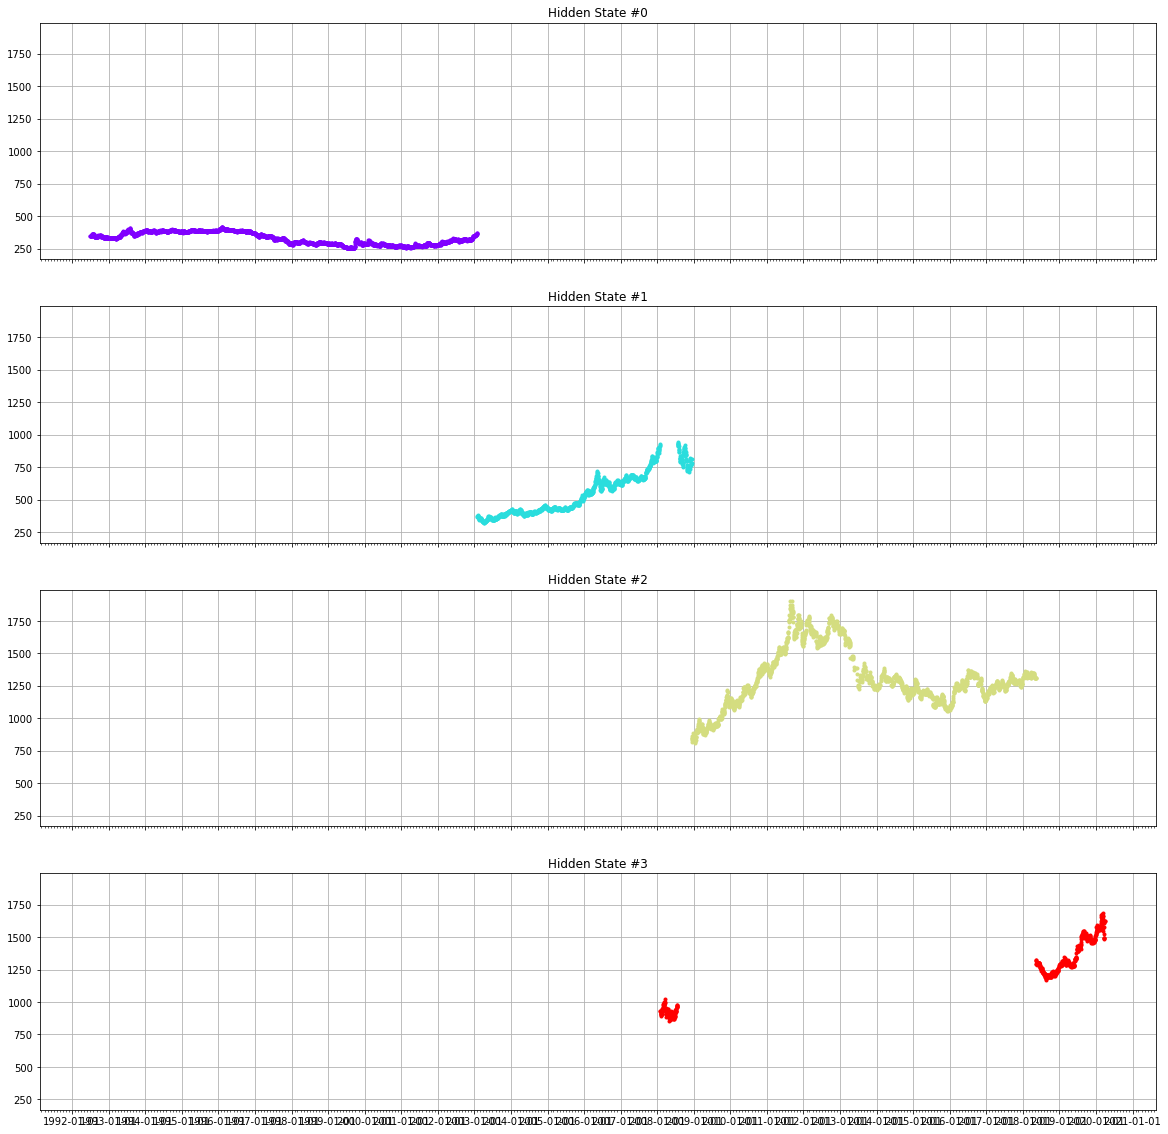

In [14]:
plot_in_sample_hidden_states(hmm_model, hard,hard['value_gold'])

In [15]:
hard_tech=pd.DataFrame()
cols=hard.columns
for x in cols:
    hard_tech['macd'+x[x.find('_'):]]=talib.MACD(hard[x])[0]
    hard_tech['rsi'+x[x.find('_'):]]=talib.RSI(hard[x])

In [16]:
hard_tech=hard_tech.dropna()
hard_tech

,macd_gold,rsi_gold,macd_oil,rsi_oil,macd_silver,rsi_silver,macd_ruth,rsi_ruth,macd_irid,rsi_irid,macd_pall,rsi_pall,macd_rhod,rsi_rhod,macd_plat,rsi_plat
Date,,,,,,,,,,,,,,,,
1992-08-17,-2.015020,29.226935,-0.094782,47.454266,-0.035345,35.921756,0.000000,0.000000,0.000000,0.0,-0.338327,37.909067,-52.572359,16.230228,-8.601771,27.342166
1992-08-18,-2.690971,28.547065,-0.078111,49.341053,-0.041041,32.603658,0.000000,0.000000,0.000000,0.0,-0.590327,37.909067,-54.600684,16.230228,-9.632496,25.480748
1992-08-19,-3.166363,29.369062,-0.080911,44.212059,-0.044238,34.239059,0.000000,0.000000,0.000000,0.0,-0.701264,42.469876,-55.567597,16.230228,-10.011183,30.570969
1992-08-20,-3.386270,33.449592,-0.076599,46.218918,-0.046239,34.239059,0.000000,0.000000,0.000000,0.0,-0.780188,42.469876,-55.691901,16.230228,-10.273560,30.018907
1992-08-21,-3.545499,32.999592,-0.089100,41.406624,-0.049673,31.573426,0.000000,0.000000,0.000000,0.0,-0.753361,46.986075,-55.154625,16.230228,-9.883416,37.331384
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-03-24,-22.269574,49.907247,-6.106278,39.354266,-1.316255,34.581511,-0.000015,0.000393,2.792981,100.0,-209.390195,41.943899,-1345.703405,16.343460,-82.100152,33.480901
2020-03-25,-15.526724,55.544042,-6.133987,39.163155,-1.201334,41.140392,-0.000014,0.000393,2.605305,100.0,-181.784565,47.506281,-1290.437784,40.052831,-75.214309,39.409258
2020-03-26,-11.004244,53.711742,-6.416848,36.345915,-1.106779,40.375002,-0.000013,0.000393,2.428575,100.0,-137.024775,56.837485,-1092.831525,49.802545,-67.526377,42.512860


In [17]:
hmm_model = GaussianHMM(
        n_components=4, covariance_type="full", n_iter=1000
    ).fit(hard_tech)
print("Model Score:", hmm_model.score(hard_tech))

Model Score: -355475.96076513827


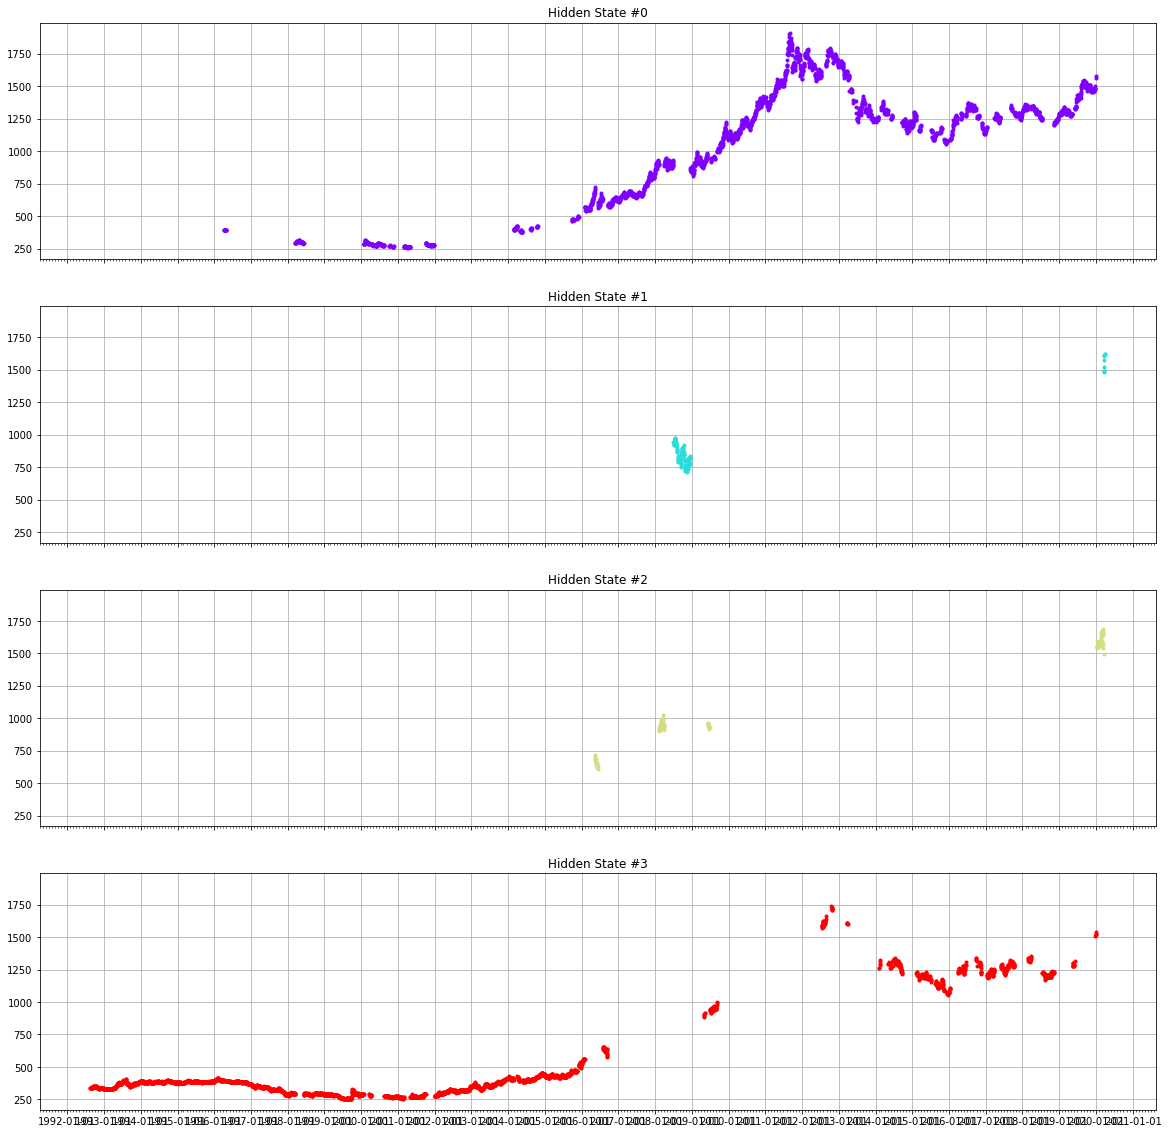

In [18]:
plot_in_sample_hidden_states(hmm_model, hard_tech,hard['value_gold']['1992-08-17':])

In [19]:
import requests
r=requests.get('https://api.worldtradingdata.com/api/v1/history?symbol=SPY&api_token=cif0zQNJZrTwHRktOAqNrz6JnYqPE4EmWtGlCawvjFYhMLMc1rVTPgZWLcMG')

In [20]:
history=r.json()['history']
closing=np.array([float(v['close']) for v in history.values()])
spy=pd.Series(closing, index=history.keys())

In [21]:
hard_tech_cut=hard_tech.loc['1993-01-29':]
spy_htc=spy[hard_tech_cut.index.strftime('%Y-%m-%d')]

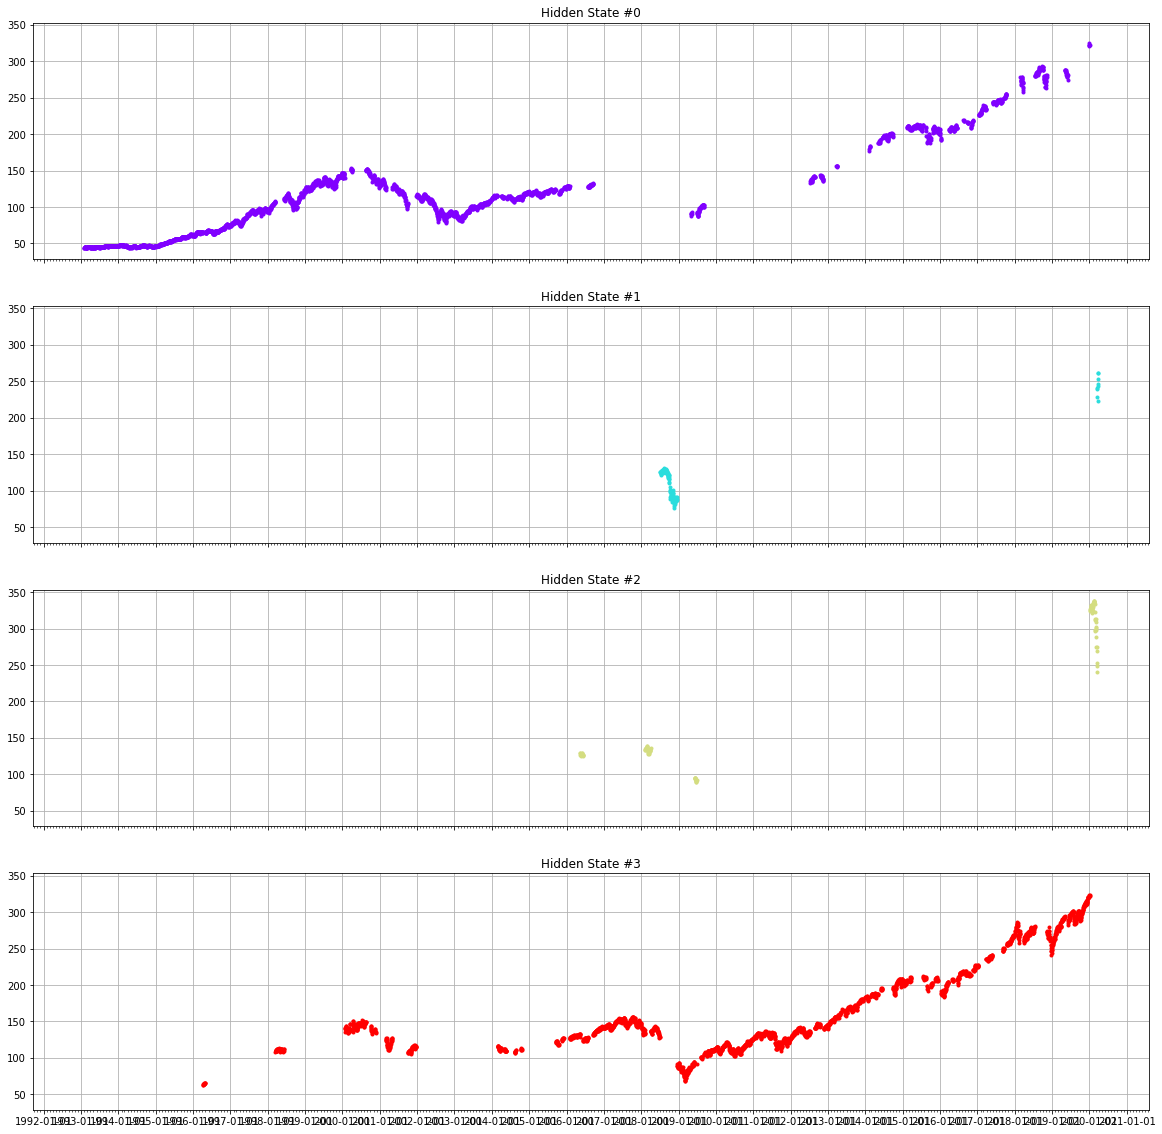

In [22]:
hmm_model = GaussianHMM(
        n_components=4, covariance_type="full", n_iter=1000
    ).fit(hard_tech_cut)
plot_in_sample_hidden_states(hmm_model, hard_tech_cut,spy_htc)

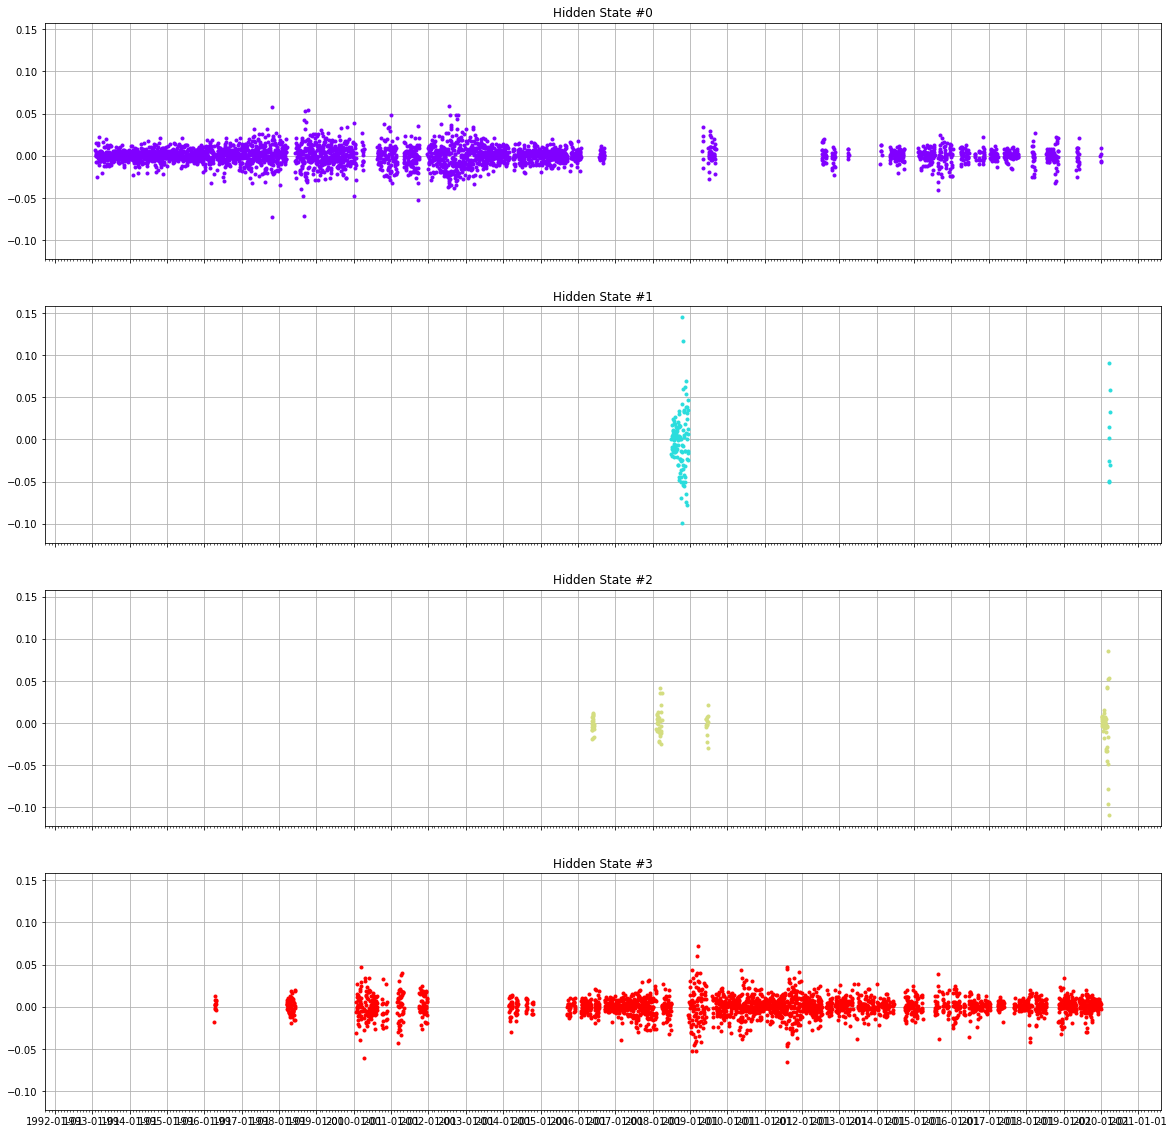

In [23]:
hmm_model = GaussianHMM(
        n_components=4, covariance_type="full", n_iter=1000
    ).fit(hard_tech_cut)
plot_in_sample_hidden_states(hmm_model, hard_tech_cut,spy_htc.pct_change())

In [24]:
hard_pct=pd.DataFrame()
cols=hard.columns
for x in cols:
    hard_pct['pct'+x[x.find('_'):]]=hard[x].pct_change()

In [25]:
def merge_with_spy(df,spy=spy):
    cut=df.loc['1993-01-29':]
    spy_out=spy[cut.index.strftime('%Y-%m-%d')]
    return cut,spy_out

hard_pct_cut,spy_pct=merge_with_spy(hard_pct,spy)

In [26]:
hard_pct_cut=hard_pct_cut.replace([np.inf, -np.inf,np.nan], 0)

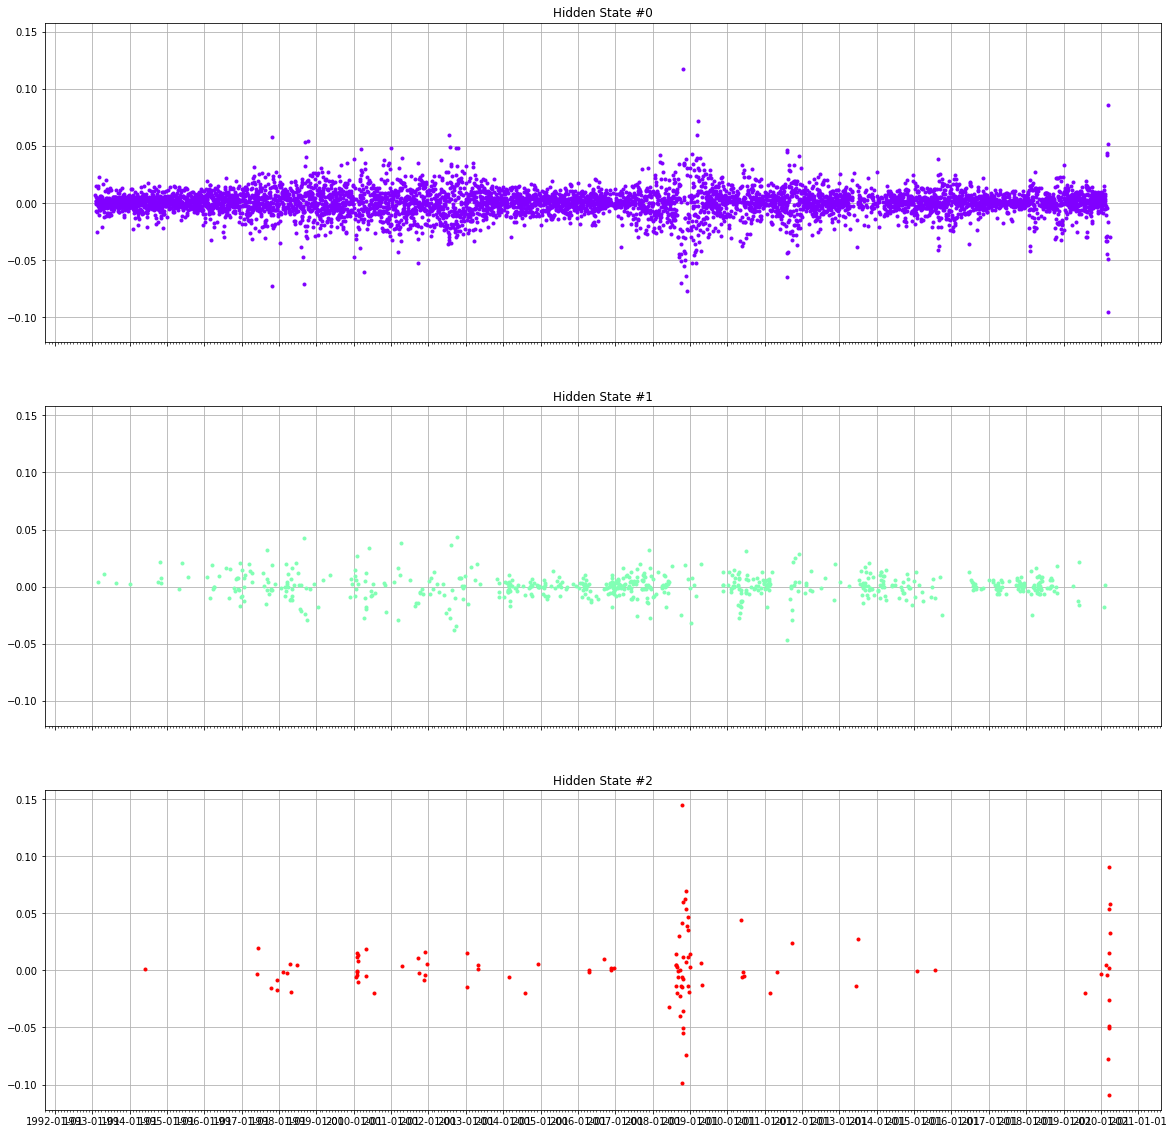

In [27]:
hmm_model = GaussianHMM(
        n_components=3, covariance_type="full", n_iter=1000
    ).fit(hard_pct_cut)
plot_in_sample_hidden_states(hmm_model, hard_pct_cut,spy_pct.pct_change())

In [28]:
import trading as td

In [ ]:
td.time_series_chart(s=spy_pct.pct_change())